In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
import torch.nn.functional as F

from torchsummary import summary

import os
import glob
import sys
sys.path.append("../../")
from utils import metrics
from utils.logger import Logger
import logging

font = {"size": 20} # 设置字体大小

In [2]:
def seq_tar_gen(raw_data, tw=16, pw=1):
    sample = []
    for i in range(len(raw_data) - tw):
        sample.append([raw_data[i:i + tw], raw_data[i + tw: i + tw + pw]])
    return sample

# sequence-target-generator测试
raw_data = np.array(range(10))
test_seq = seq_tar_gen(raw_data=raw_data, tw=6, pw=1)
for seq in test_seq:
    print(seq)

[array([0, 1, 2, 3, 4, 5]), array([6])]
[array([1, 2, 3, 4, 5, 6]), array([7])]
[array([2, 3, 4, 5, 6, 7]), array([8])]
[array([3, 4, 5, 6, 7, 8]), array([9])]


In [3]:
# Dataset
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sample = self.data[index]
        seq = torch.FloatTensor(sample[0])
        tar = torch.FloatTensor(sample[1])
        return seq, tar

In [25]:
# 线性回归模型
# class LinearRegression(nn.Module):
#     def __init__(self):
#         super(LinearRegression, self).__init__()
#         self.linear = nn.Linear(16, 1)

#     def forward(self, x):
#         return self.linear(x)

# net = nn.Sequential(nn.Linear(16, 1))

# CALCE数据集

In [4]:
# 读取数据集
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
calce_data = np.load(calce_data_path, allow_pickle=True)
b35 = calce_data[0]
b36 = calce_data[1]
b37 = calce_data[2]
b38 = calce_data[3]

# 构造（16，1）样本
window_size = 16
b35 = seq_tar_gen(b35, window_size)
b36 = seq_tar_gen(b36, window_size)
b37 = seq_tar_gen(b37, window_size)
b38 = seq_tar_gen(b38, window_size)

print(b35[0]) # 测试生成的样本的正确性
print(BatteryDataset(b35)[0])

[array([1.12638451, 1.12615982, 1.12596571, 1.11850769, 1.11721007,
       1.11375355, 1.09881814, 1.09618033, 1.08987113, 1.0875823 ,
       1.09474789, 1.09556829, 1.09543292, 1.09522322, 1.09480406,
       1.09444488]), array([1.09404421])]
(tensor([1.1264, 1.1262, 1.1260, 1.1185, 1.1172, 1.1138, 1.0988, 1.0962, 1.0899,
        1.0876, 1.0947, 1.0956, 1.0954, 1.0952, 1.0948, 1.0944]), tensor([1.0940]))


Save log to: ../../logs/2023_06_15_09_53_calce_lr.log


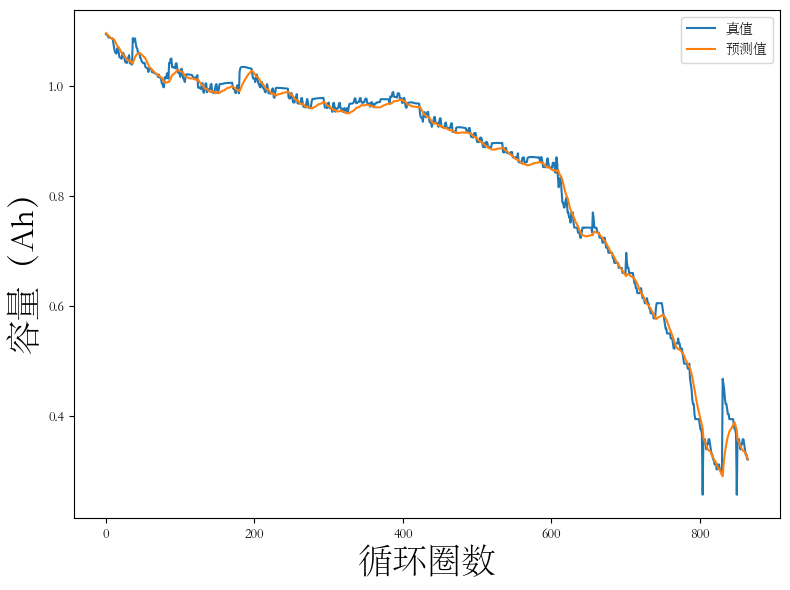

2023-06-15 09:53:31,797 - calce_lr - INFO - test dataset: CS2_35, maxE: 0.177502, mae: 0.009936, rmse:0.016692
2023-06-15 09:53:31,797 - calce_lr - INFO - test dataset: CS2_35, maxE: 0.177502, mae: 0.009936, rmse:0.016692
2023-06-15 09:53:31,797 - calce_lr - INFO - test dataset: CS2_35, maxE: 0.177502, mae: 0.009936, rmse:0.016692
2023-06-15 09:53:31,797 - calce_lr - INFO - test dataset: CS2_35, maxE: 0.177502, mae: 0.009936, rmse:0.016692


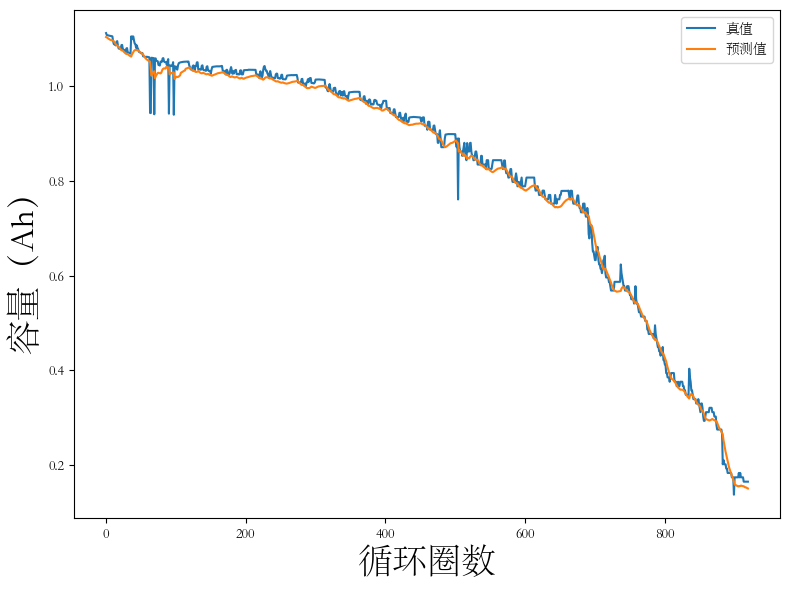

2023-06-15 09:53:34,083 - calce_lr - INFO - test dataset: CS2_36, maxE: 0.118616, mae: 0.012172, rmse:0.016608
2023-06-15 09:53:34,083 - calce_lr - INFO - test dataset: CS2_36, maxE: 0.118616, mae: 0.012172, rmse:0.016608
2023-06-15 09:53:34,083 - calce_lr - INFO - test dataset: CS2_36, maxE: 0.118616, mae: 0.012172, rmse:0.016608
2023-06-15 09:53:34,083 - calce_lr - INFO - test dataset: CS2_36, maxE: 0.118616, mae: 0.012172, rmse:0.016608


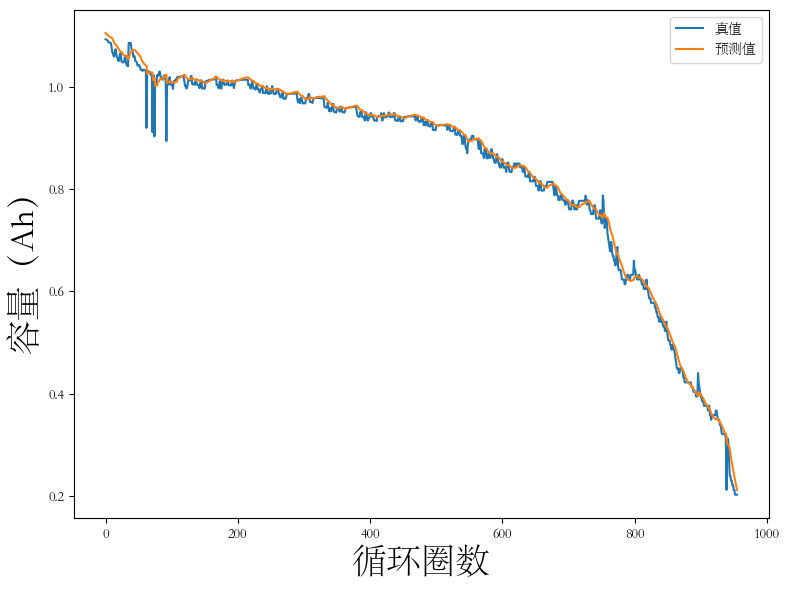

2023-06-15 09:53:36,338 - calce_lr - INFO - test dataset: CS2_37, maxE: 0.129575, mae: 0.009314, rmse:0.014511
2023-06-15 09:53:36,338 - calce_lr - INFO - test dataset: CS2_37, maxE: 0.129575, mae: 0.009314, rmse:0.014511
2023-06-15 09:53:36,338 - calce_lr - INFO - test dataset: CS2_37, maxE: 0.129575, mae: 0.009314, rmse:0.014511
2023-06-15 09:53:36,338 - calce_lr - INFO - test dataset: CS2_37, maxE: 0.129575, mae: 0.009314, rmse:0.014511


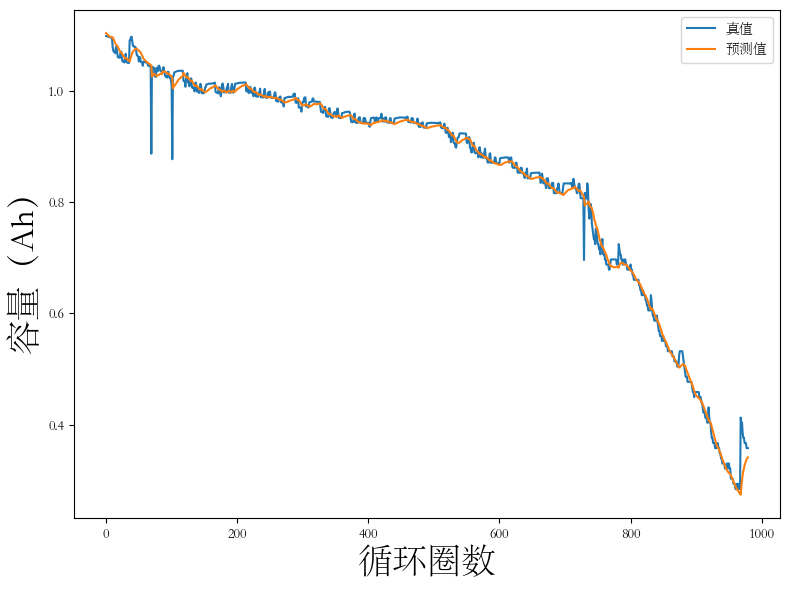

2023-06-15 09:53:38,584 - calce_lr - INFO - test dataset: CS2_38, maxE: 0.158676, mae: 0.008667, rmse:0.014677
2023-06-15 09:53:38,584 - calce_lr - INFO - test dataset: CS2_38, maxE: 0.158676, mae: 0.008667, rmse:0.014677
2023-06-15 09:53:38,584 - calce_lr - INFO - test dataset: CS2_38, maxE: 0.158676, mae: 0.008667, rmse:0.014677
2023-06-15 09:53:38,584 - calce_lr - INFO - test dataset: CS2_38, maxE: 0.158676, mae: 0.008667, rmse:0.014677


In [8]:
# 设置日志模块
logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="calce_lr" # linear regression
    ).get_logger()

# 模型训练
lr = 0.01
epochs = 10
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = (b35, b36, b37, b38)
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = nn.Sequential(nn.Linear(16, 1)).to(device)
    model[0].weight.data.normal_(0, 0)
    model[0].bias.data.fill_(0)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    train_loss, val_loss = 0.0, 0.0
    for epoch in range(epochs):
        model.train()
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

    
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
    
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数", font)
    plt.ylabel("容量（Ah）", font)
    save_path = f"../../assets/thesis_figures/chapter_3/calce_{battery_names[idx]}_lr.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    maxE, mae, rmse = metrics.evaluation(gt, y_pred)
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")

# NASA PCoE数据集

In [9]:
# 读取数据集
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)

b05 = nasa_data[0]
b06 = nasa_data[1]
b07 = nasa_data[2]
b18 = nasa_data[3]

# 构造（16，1）样本
window_size = 16
b05 = seq_tar_gen(b05, window_size)
b06 = seq_tar_gen(b06, window_size)
b07 = seq_tar_gen(b07, window_size)
b18 = seq_tar_gen(b18, window_size)

print(b05[0])

[array([1.85648742, 1.84632725, 1.83534919, 1.83526253, 1.83464551,
       1.83566166, 1.83514614, 1.82575679, 1.82477385, 1.82461327,
       1.82461955, 1.81420194, 1.81375216, 1.81344049, 1.802598  ,
       1.8021069 ]), array([1.8025795])]


using device: cuda
Save log to: ../../logs/2023_06_15_09_56_nasa_lr.log


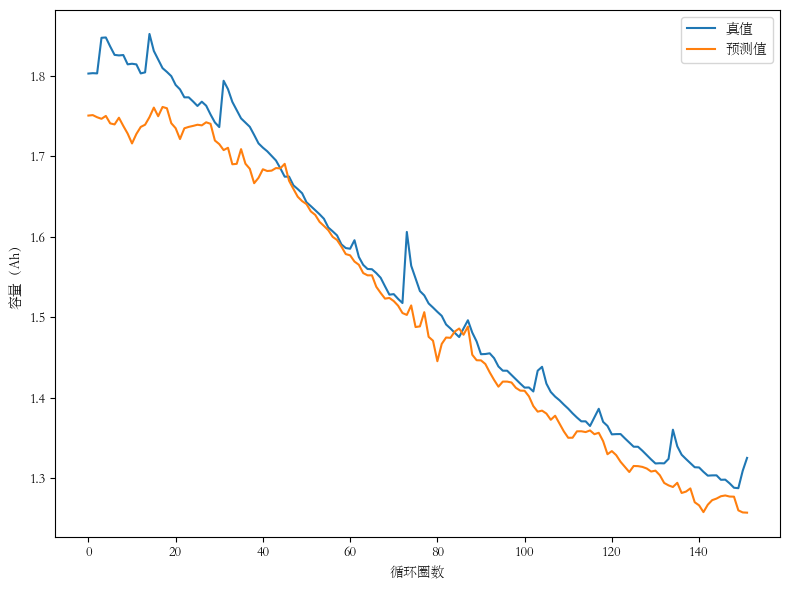

2023-06-15 09:56:11,478 - nasa_lr - INFO - test dataset: B0005, maxE: 0.103376, mae: 0.032867, rmse:0.041595


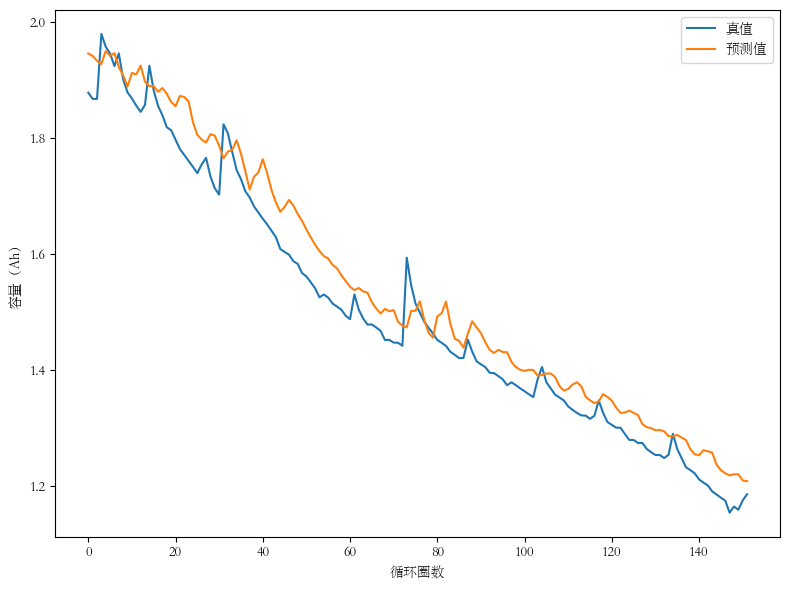

2023-06-15 09:56:12,623 - nasa_lr - INFO - test dataset: B0006, maxE: 0.120192, mae: 0.045992, rmse:0.051837


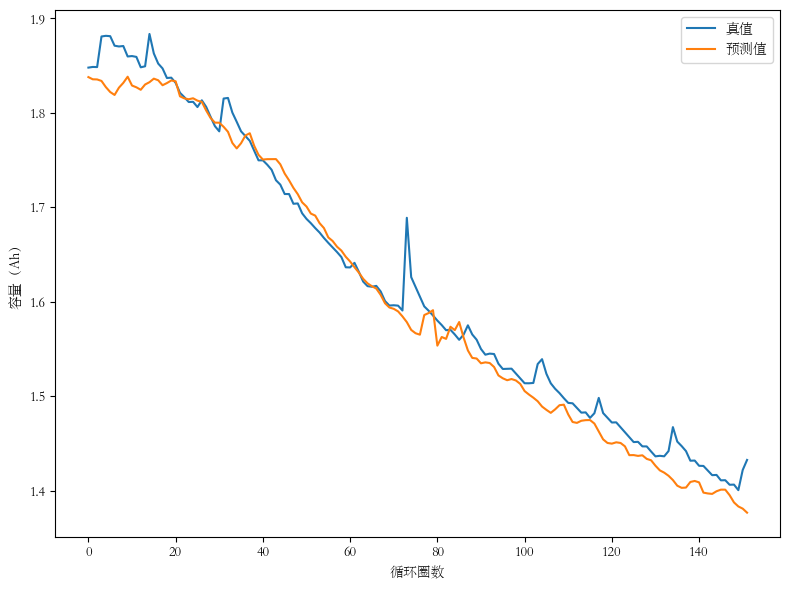

2023-06-15 09:56:13,769 - nasa_lr - INFO - test dataset: B0007, maxE: 0.110464, mae: 0.017827, rmse:0.024007


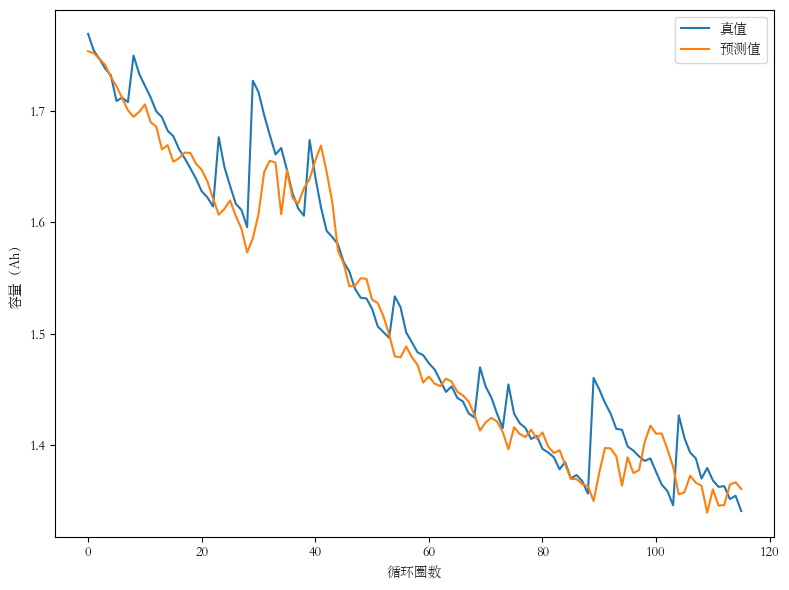

2023-06-15 09:56:14,944 - nasa_lr - INFO - test dataset: B0018, maxE: 0.141262, mae: 0.022326, rmse:0.032518


In [10]:
# 模型训练
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

epochs = 20
lr = 1e-2
window_size = 16
batch_size = 16

dataset = (b05, b06, b07, b18)
battery_names = ["B0005", "B0006", "B0007", "B0018"]

logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="nasa_lr"
    ).get_logger()

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = nn.Sequential(nn.Linear(16, 1)).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    train_loss, val_loss = 0.0, 0.0
    for epoch in range(epochs):
        model.train()
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

    # 可视化验证集上结果
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
        

    # ax[idx].plot(gt)
    # # plt.fill_between(cycle, y1, y2, alpha=0.5)
    # ax[idx].plot(y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数", font)
    plt.ylabel("容量（Ah）", font)
    save_path = f"../../assets/thesis_figures/chapter_3/nasa_{battery_names[idx]}_lr.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    maxE, mae, rmse = metrics.evaluation(gt, y_pred)
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")